# Assignment #2

## Problem
### Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

## Data description

### There are 3 types of input features:

### Objective: factual information;
### Examination: results of medical examination;
### Subjective: information given by the patient.

## Part 1. Preliminary data analysis

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rcParams

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18})

rcParams["figure.figsize"] = 11, 8

In [2]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


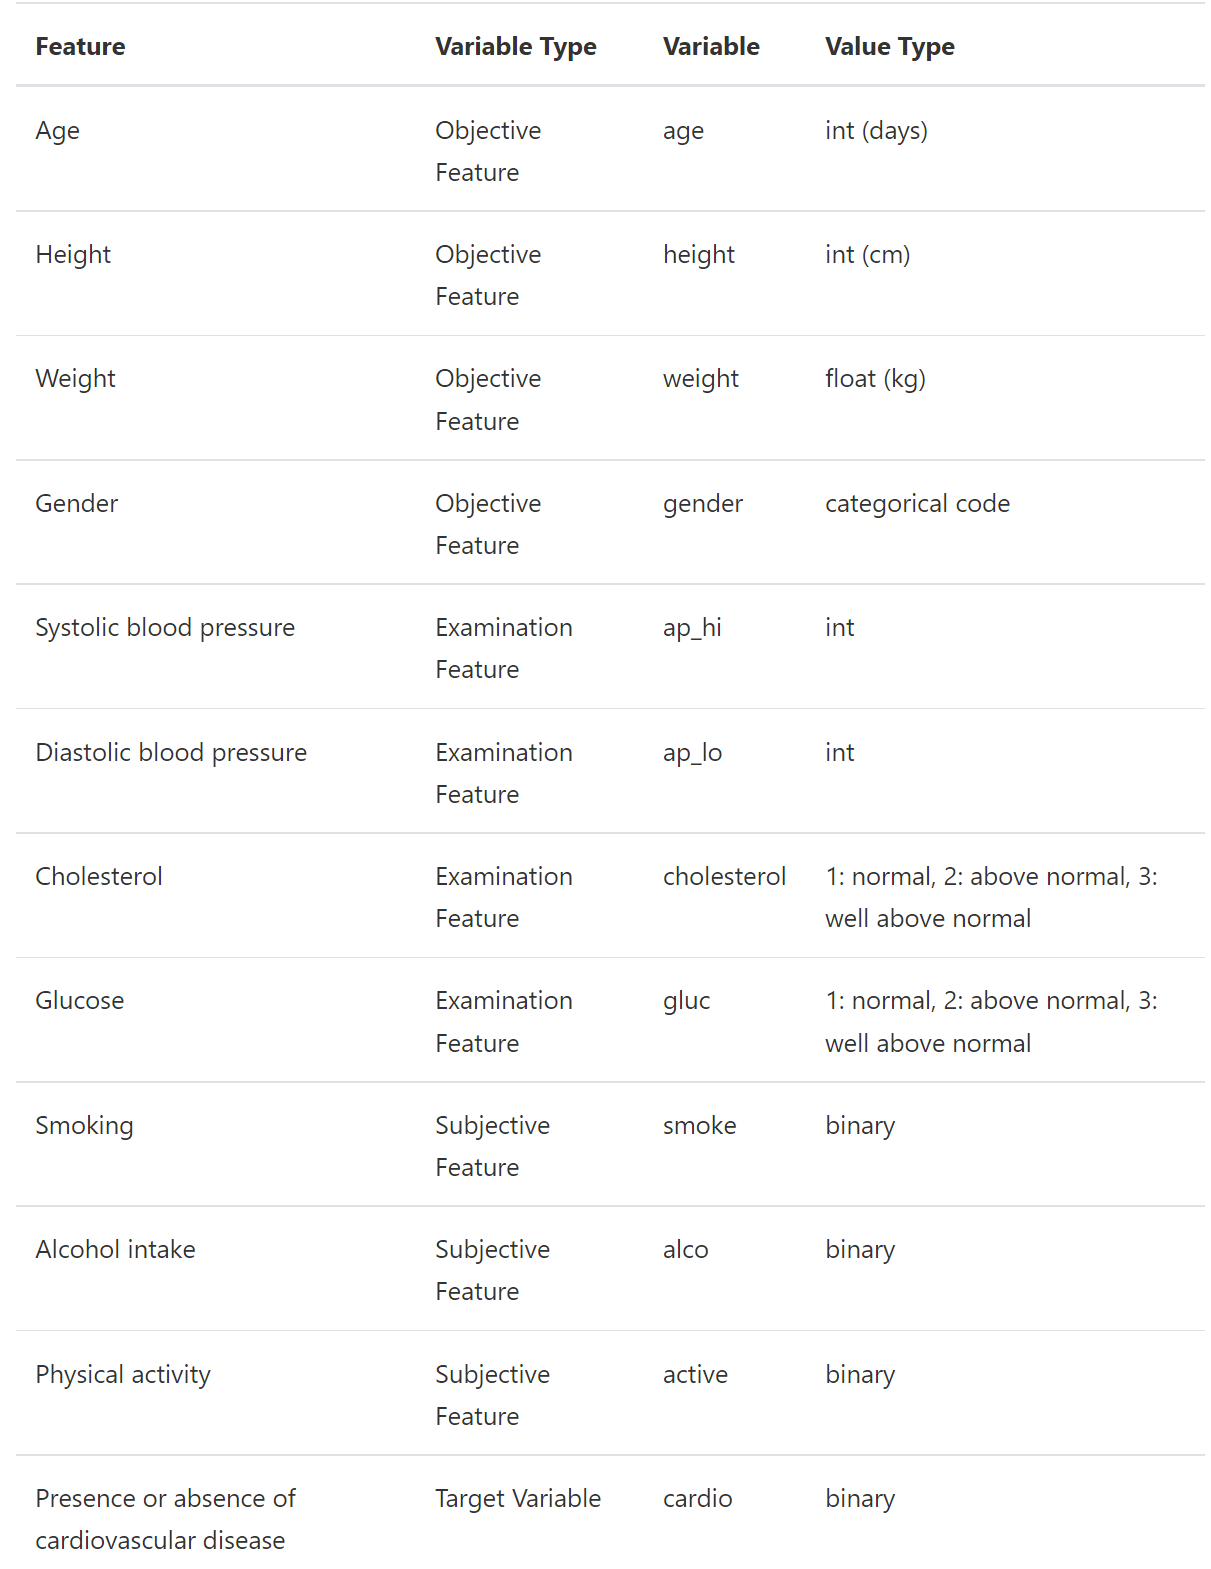

In [3]:
from IPython.display import Image
Image(filename='images/DataFeatureDescription.PNG', width=500, height=600)

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)

print(df_uniques)

       variable  value
0        gender      2
1        gender      1
2        gender      1
3        gender      2
4        gender      1
...         ...    ...
489995   cardio      0
489996   cardio      1
489997   cardio      1
489998   cardio      1
489999   cardio      0

[490000 rows x 2 columns]


<AxesSubplot:xlabel='variable', ylabel='count'>

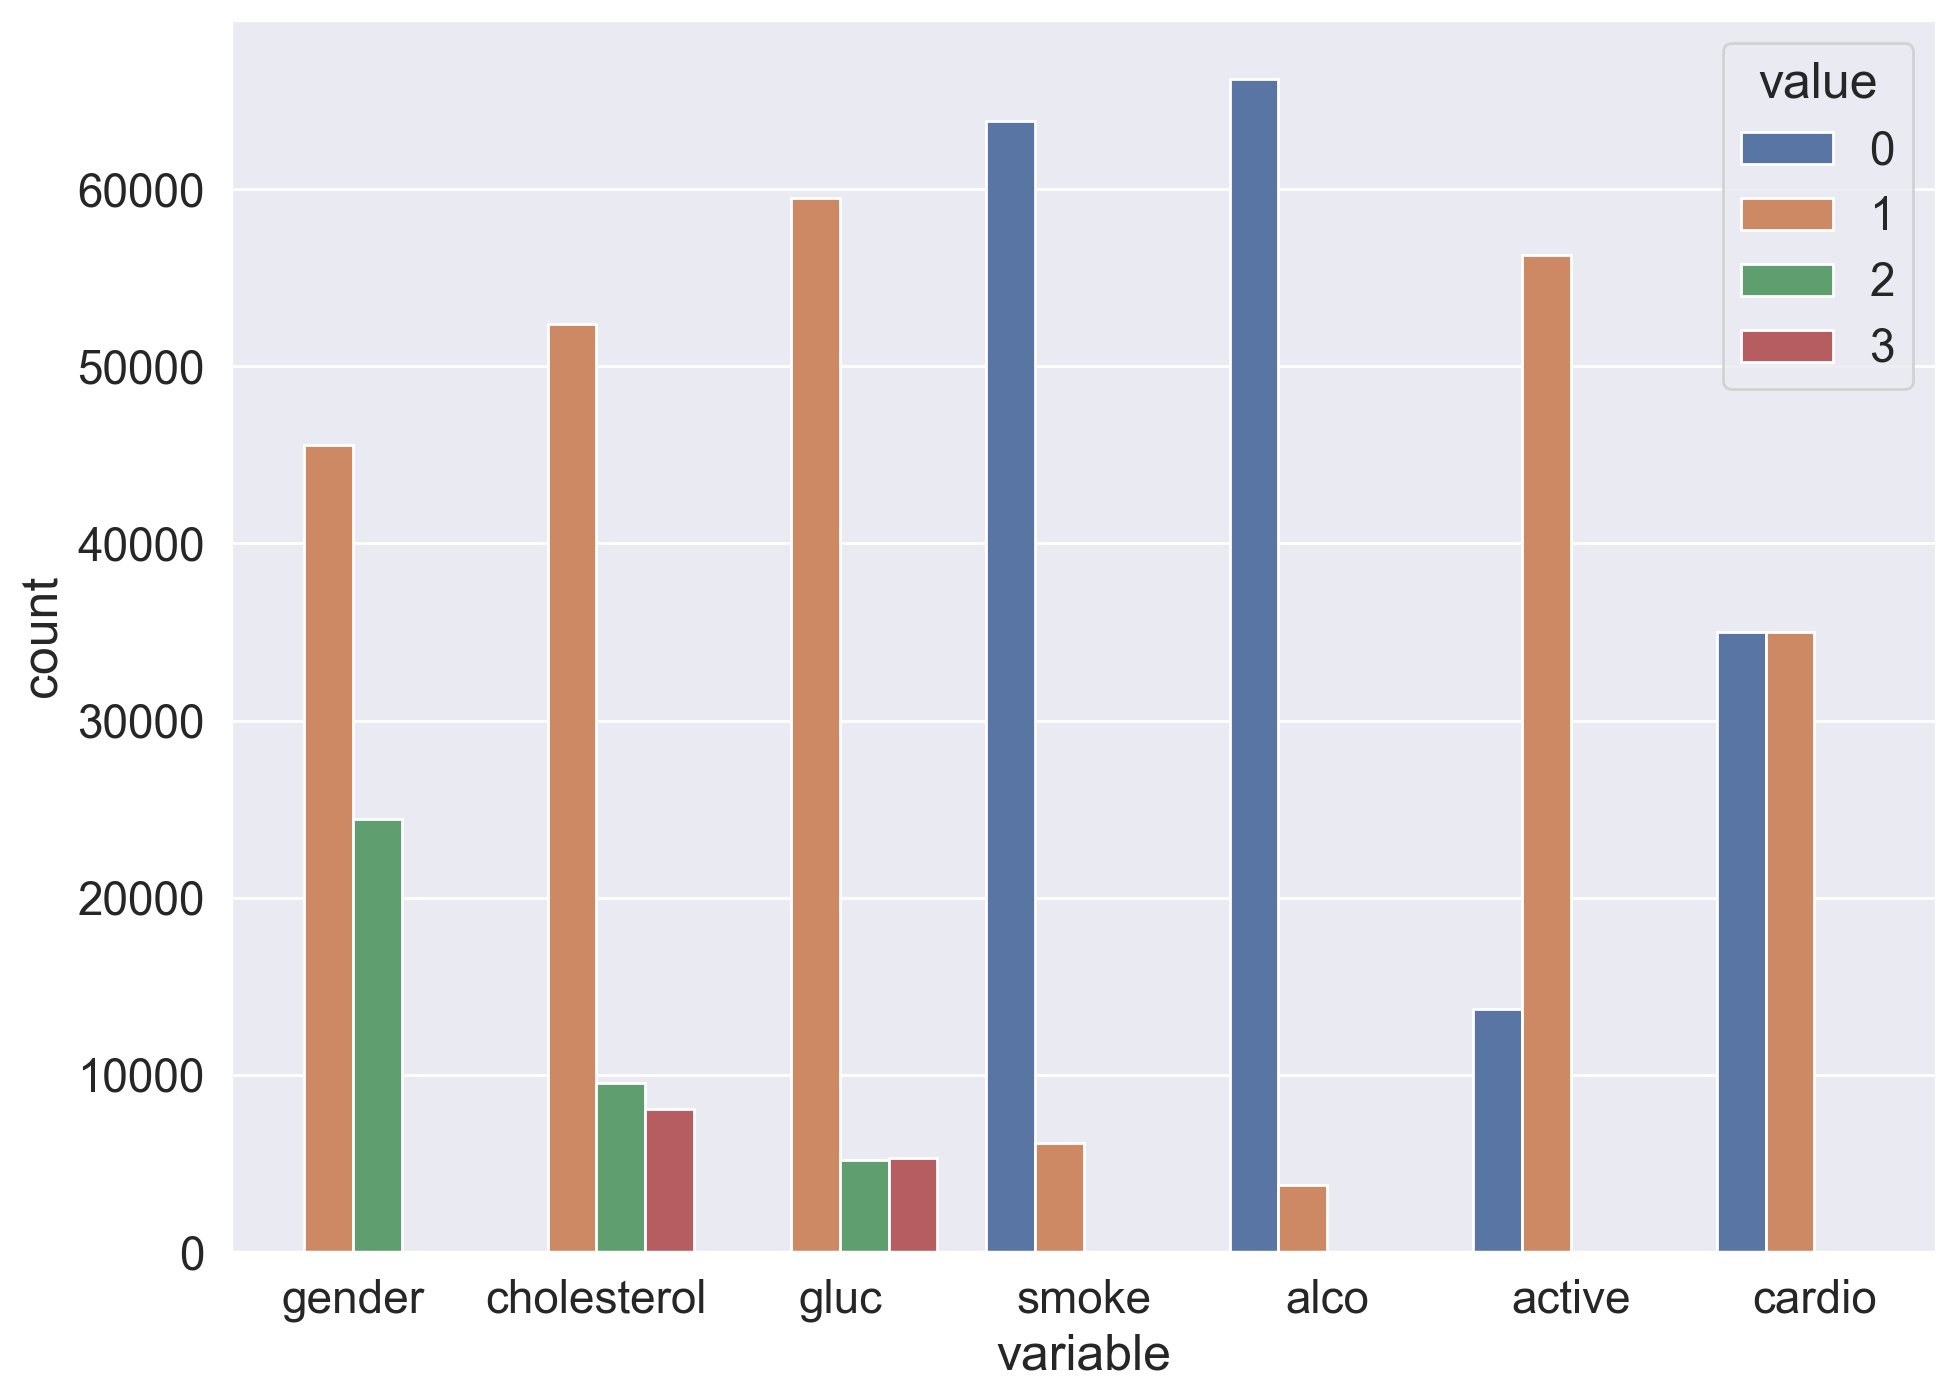

In [5]:
sns.countplot(x="variable", hue="value", data=df_uniques)

[Text(0.5, 1.0, 'Cardio 1')]

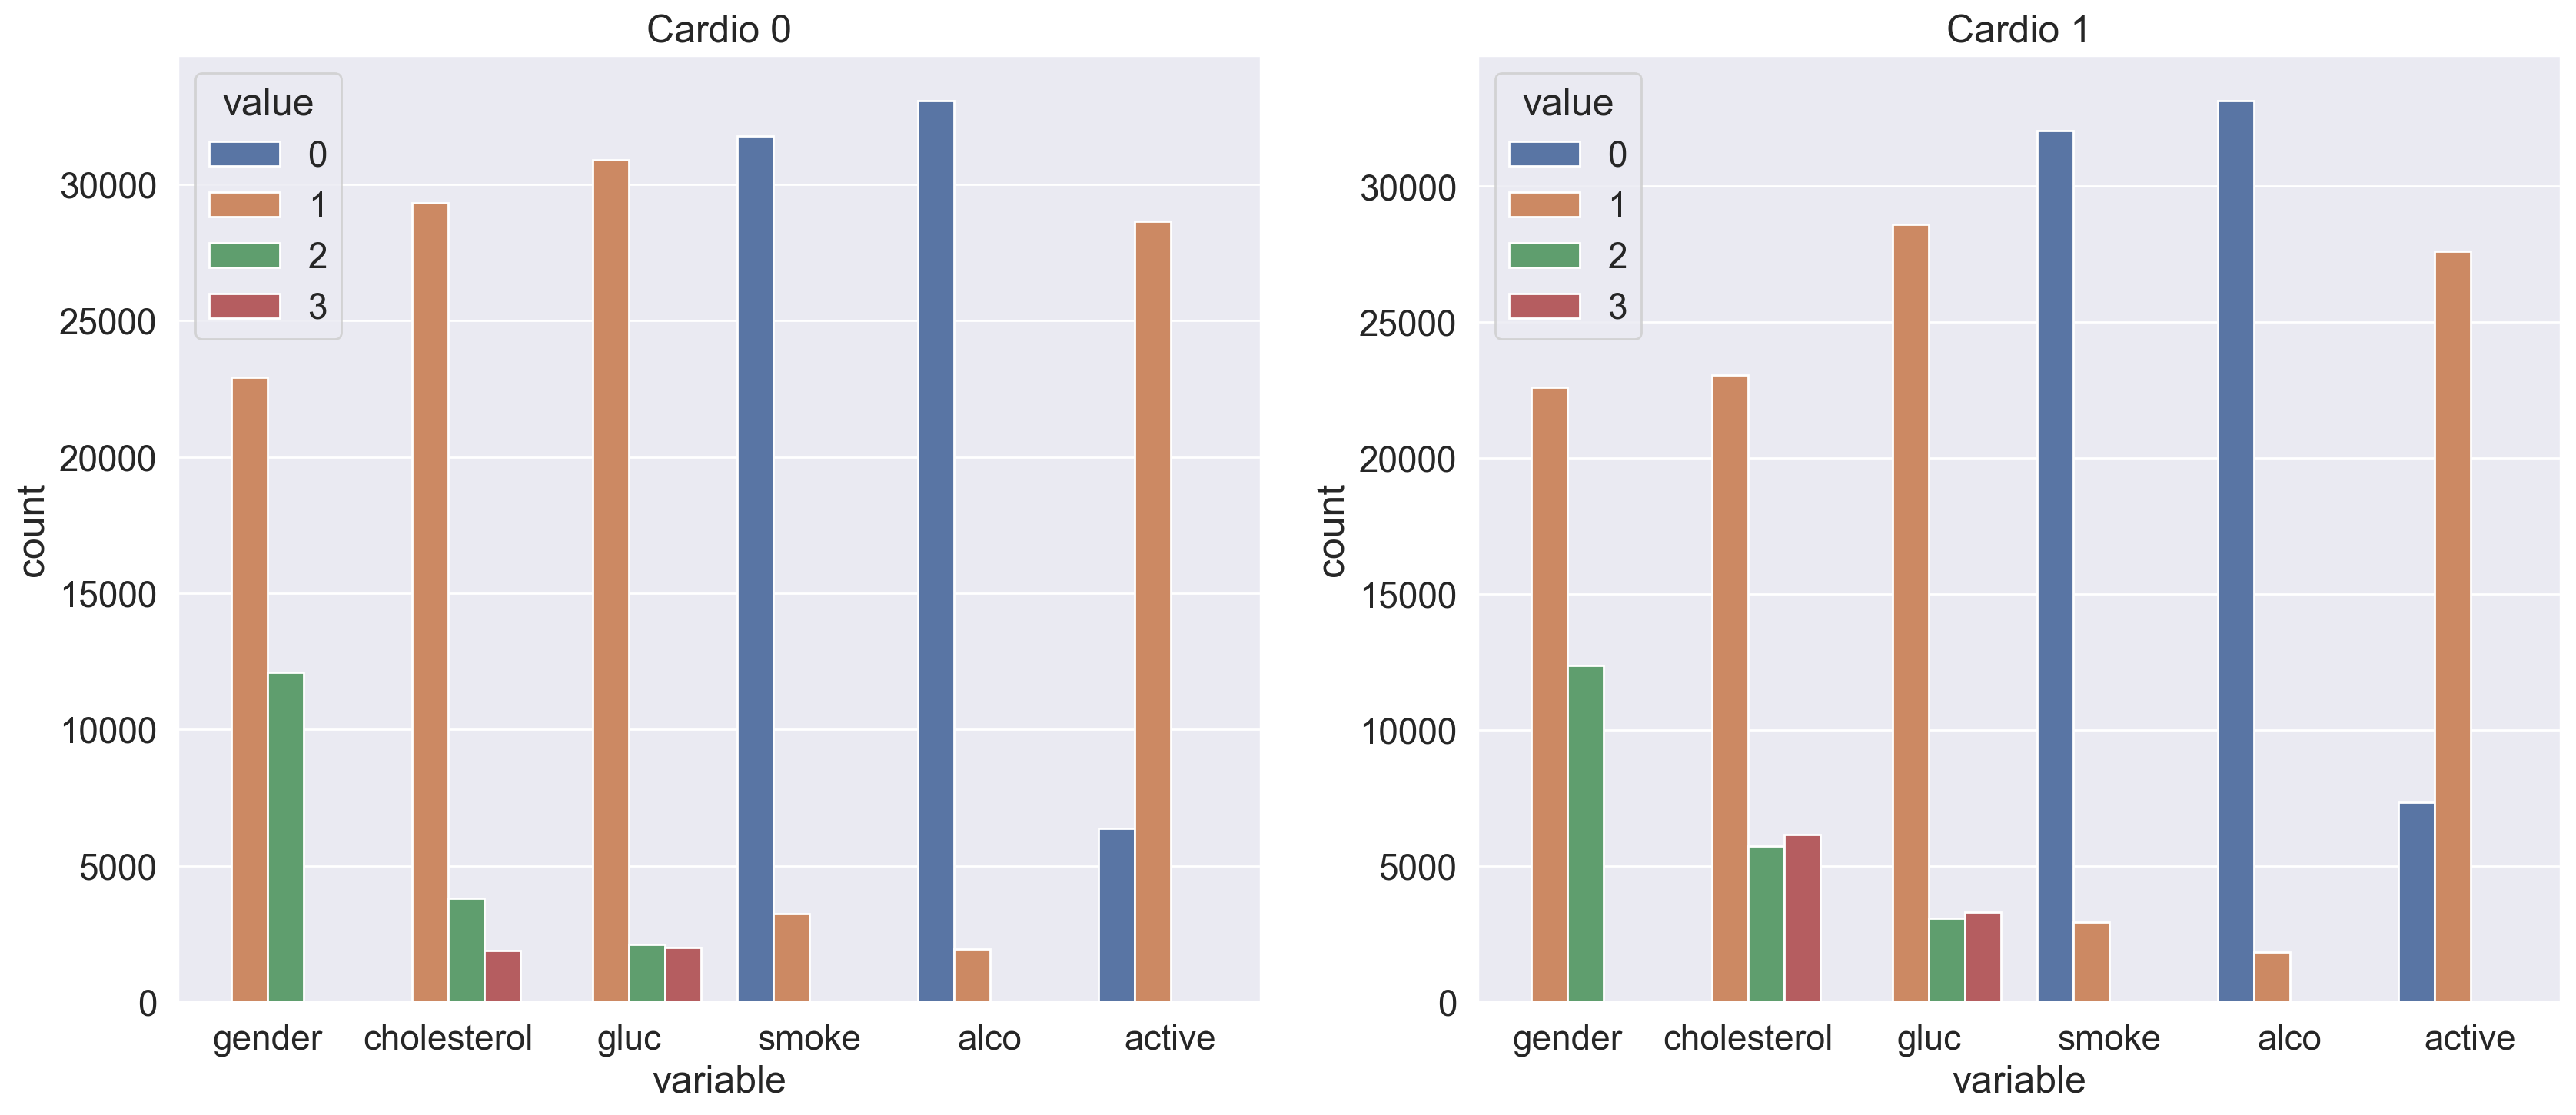

In [6]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
sns.countplot(x="variable", hue="value", data=df_uniques[df_uniques["cardio"] == 0], ax=axis[0]).set(title="Cardio 0")
sns.countplot(x="variable", hue="value", data=df_uniques[df_uniques["cardio"] == 1], ax=axis[1]).set(title="Cardio 1")

### ^^You can see that the distribution of cholesterol and glucose levels greatly differs by the value of the target variable.

In [7]:
for c in df.columns:
    n =df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10* '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


## 1.1. Basic observations

### Question 1.1. (1 point). How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [8]:
df.groupby("gender")["height"].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

answer: 
Gender 1 - 45530 women, Gender 2 - 24470 men

### Question 1.2. (1 point). Who more often report consuming alcohol – men or women?

In [9]:
df.groupby("gender")["alco"].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

answer: Men report consuming alcohol more often

### Question 1.3. (1 point). What’s the rounded difference between the percentages of smokers among men and women?

In [10]:
df.groupby("gender")["smoke"].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

In [11]:
diff = round(
    (df.groupby("gender")["smoke"].mean()[2]
     - df.groupby("gender")["smoke"].mean()[1]) * 100)

print(f"rounded difference is {diff}%")

rounded difference is 20%


### Question 1.4. (1 point). What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.

In [12]:
round(df['age'][:5]/365.25, 2)
# looks like age value is given in days

0    50.36
1    55.38
2    51.63
3    48.25
4    47.84
Name: age, dtype: float64

In [13]:
round(df.groupby("smoke")["age"].median()/365.25 * 12)
# *12 because we need months

smoke
0    648.0
1    628.0
Name: age, dtype: float64

In [14]:
round(
    (df.groupby("smoke")["age"].median()[0]/365.25 * 12)
     - (df.groupby("smoke")["age"].median()[1]/365.25 * 12))

20

## 1.2. Risk maps

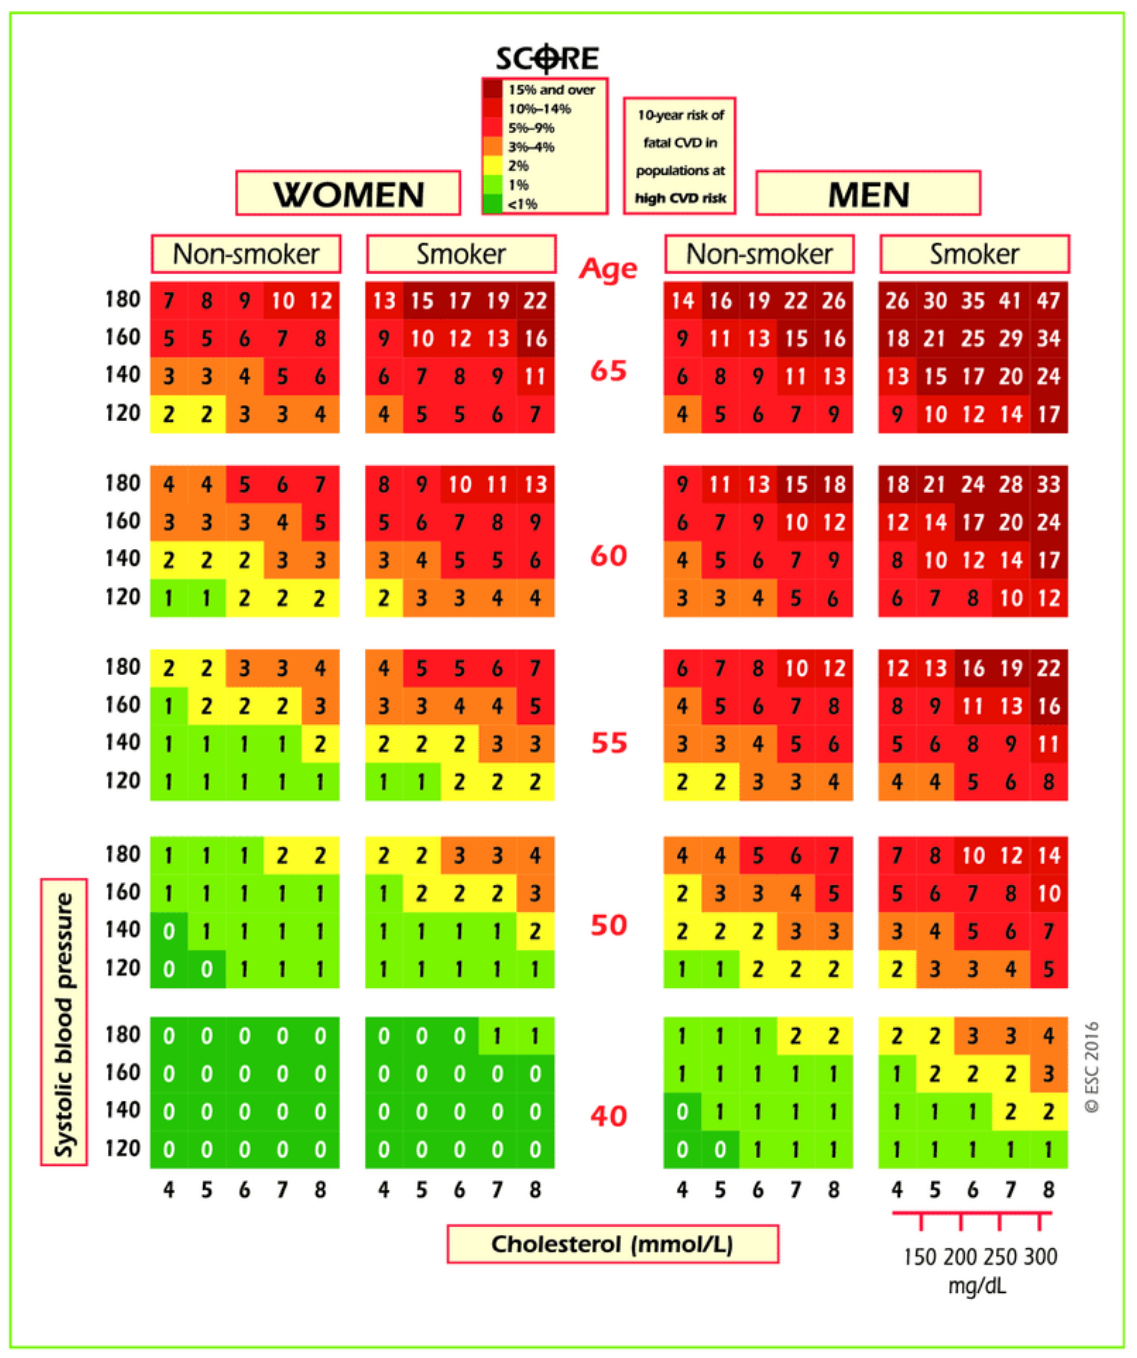

In [15]:
from IPython.display import Image
Image(filename='images/RiskMapPNG.PNG', width=600, height=600)

Let’s take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65.

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let’s calculate that same ratio using our data.

Clarifications:

Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.

Cholesterol level categories differ between the figure and our dataset. The conversion for the cholesterol feature is as follows: 4 mmol/l -> 1,
            5-7 mmol/l -> 2,
            8 mmol/l -> 3.

In [16]:
df["age_years"] = (df["age"]/365.25).round().astype('int64')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,61
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,62
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0,54


### Question 1.5. (2 points). Calculate fractions of ill male gender people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [17]:
smoking_old_men = df[
    (df['age_years'] >= 60)
    & (df['age_years'] < 65)
    & (df['gender'] == 2)
    & (df['smoke'] == 1)]
smoking_old_men.head(6)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
19,29,21755,2,162,56.0,120,70,1,1,1,0,1,0,60
38,52,23388,2,162,72.0,130,80,1,1,1,0,1,1,64
67,90,22099,2,171,97.0,150,100,3,1,1,0,1,1,61
177,240,21848,2,170,69.0,120,80,1,1,1,1,1,0,60
182,248,22671,2,174,74.0,130,80,3,1,1,0,1,1,62
230,318,23376,2,175,75.0,180,100,3,1,1,1,1,1,64


In [18]:
smoking_old_men[(smoking_old_men["ap_hi"] < 120) 
  & (smoking_old_men['cholesterol'] == 1)]['cardio'].mean()

0.2631578947368421

In [19]:
smoking_old_men[(smoking_old_men["ap_hi"] >=160)
  & (smoking_old_men["ap_hi"] < 180)
  & (smoking_old_men['cholesterol'] == 3)]['cardio'].mean()

0.8636363636363636

In [20]:
val_1 = smoking_old_men[(smoking_old_men["ap_hi"] < 120)
        & (smoking_old_men['cholesterol'] == 1)]['cardio'].mean()
val_2 = smoking_old_men[(smoking_old_men["ap_hi"] >=160)
        & (smoking_old_men["ap_hi"] < 180)
        & (smoking_old_men['cholesterol'] == 3)]['cardio'].mean()

fraction = round(val_2/val_1,2)
print(fraction)

3.28


As a result, the difference is approximately 3-fold. Not 5-fold, as the SCORE scale tells us, but it’s possible that the SCORE risk of CVD is nonlinearly dependent on the proportion of ill people in the given age group.

## 1.3. Analyzing BMI
#### Create a new feature – BMI (Body Mass Index). To do this, divide weight in kilograms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.



### Question 1.6. (2 points). Choose the correct statements:

1. Median BMI in the sample is within boundaries of normal values.

2. Women’s BMI is on average higher then men’s.

3. Healthy people have higher median BMI than ill people.

4. In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women

In [21]:
df["BMI"] = df["weight"] / (df["height"] / 100) ** 2
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


In [22]:
# 1. Median BMI in the sample is within boundaries of normal values.
df["BMI"].median()

# False

26.374068120774975

In [23]:
# 2. Women’s BMI is on average higher then men’s.
bmi_men = df[df['gender'] == 2]['BMI'].mean().round(2)
bmi_women = df[df['gender'] == 1]['BMI'].mean().round(2)
print(f"men BMI: {bmi_men}, women BMI: {bmi_women}")

# True

men BMI: 26.75, women BMI: 27.99


In [24]:
# 3. Healthy people have higher median BMI than ill people.
df.groupby(["cardio"])["BMI"].median()

# False

cardio
0    25.476660
1    27.471384
Name: BMI, dtype: float64

In [25]:
# 4. In the segment of healthy and non-drinking
# men BMI is closer to the norm than in the segment of healthy and non-drinking women
df.groupby(["cardio", "alco", "gender"])["BMI"].mean()[:2]

# True

cardio  alco  gender
0       0     1         26.845407
              2         25.872638
Name: BMI, dtype: float64

Correct statments are 2 and 4

## 1.4. Cleaning data

We can notice, that the data is not perfect. It contains much of “dirt” and inaccuracies. We’ll see it better when we do data visualization.

Filter out the following patient segments (that we consider to have erroneous data)

* diastolic pressure is higher then systolic.

* height is strictly less than 2.5%-percentile (use pd.Series.quantile. If not familiar with it – please read the docs)

* height is strictly more than 97.5%-percentile

* weight is strictly less then 2.5%-percentile

* weight is strictly more than 97.5%-percentile

This is not all we can do to clean the data, but let’s stop here by now.

### Question 1.7. (2 points). What percent of the original data (rounded) did we filter out in the previous step?

In [26]:
original_size = len(df)
print(original_size)

70000


In [27]:
lowe_percentile = df.quantile(q=0.025)
high_percentile = df.quantile(q=0.975)
print(lowe_percentile[["height", "weight"]])
print(20* '-')
print(high_percentile[["height", "weight"]])

height    150.0
weight     51.0
Name: 0.025, dtype: float64
--------------------
height    180.0
weight    108.0
Name: 0.975, dtype: float64


In [28]:
df = df[
    (df["ap_lo"] < df["ap_hi"])
    & (df["height"] >= df["height"].quantile(q=0.025))
    & (df["height"] <= df["height"].quantile(q=0.975))
    & (df["weight"] >= df["weight"].quantile(q=0.025))
    & (df["weight"] <= df["weight"].quantile(q=0.975))]
new_size = len(df)

In [29]:
print(f"We filtered around {round(100 - (new_size/original_size * 100))}% of the data")

We filtered around 10% of the data


## Part 2. Visual data analysis

### 2.1. Correlation matrix visualization

### Question 2.1. (1 point). Which pair of features has the strongest Pearson’s correlation with the gender feature?
1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

<AxesSubplot:>

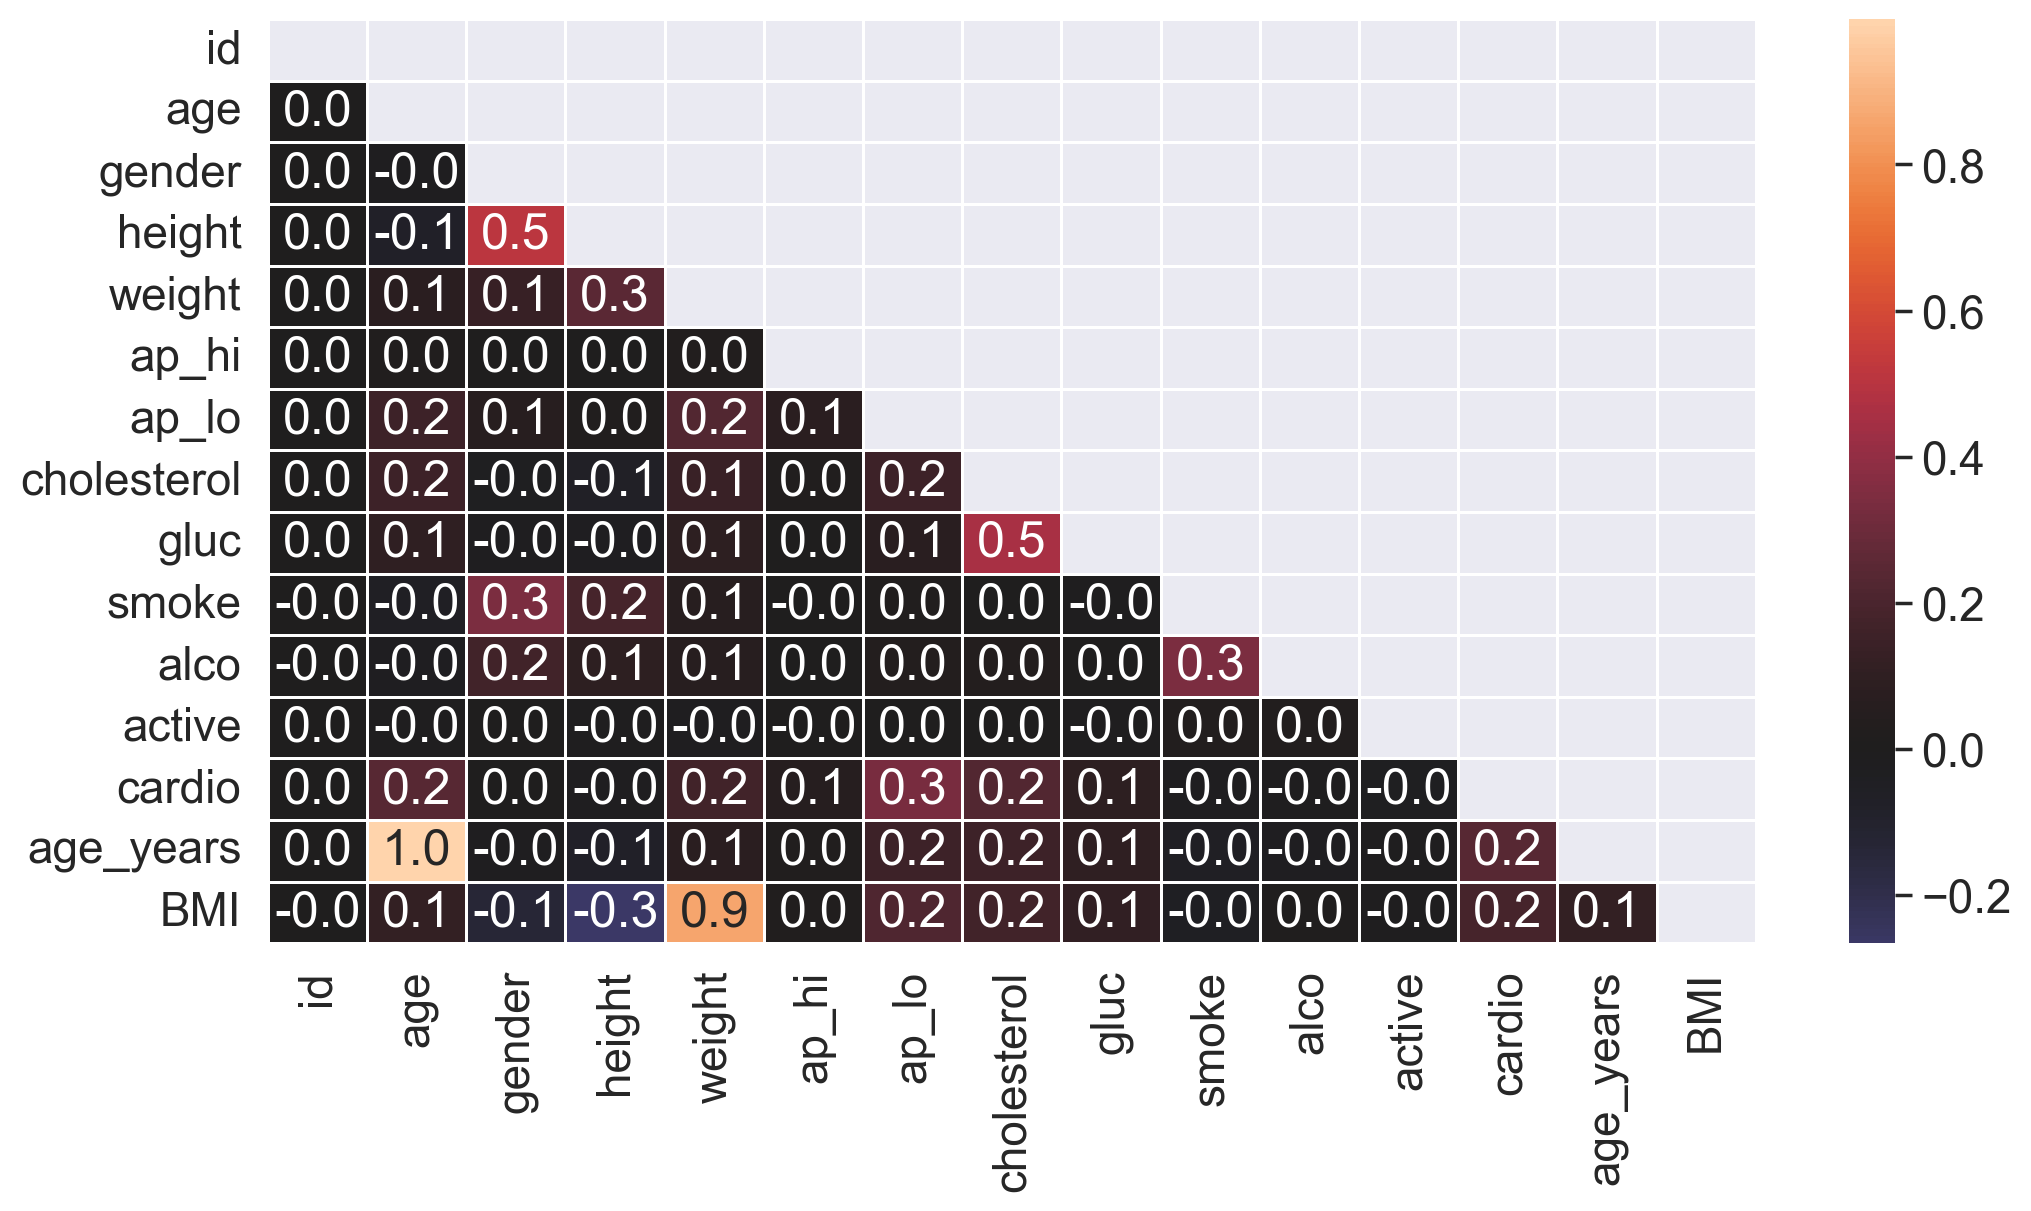

In [30]:
corr = df.corr(method="pearson")

_, axis = plt.subplots(figsize=(12,6))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, fmt='.1f', mask=mask, annot=True,center=0, linewidths=0.5, ax=axis)

answer: height and smoke

## 2.2. Height distribution of men and women

### Create a violin plot for the height and gender using violinplot(). Use the parameters:

* hue to split by gender;
* scale to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your DataFrame to long format using the melt() function from pandas.

<AxesSubplot:xlabel='variable', ylabel='value'>

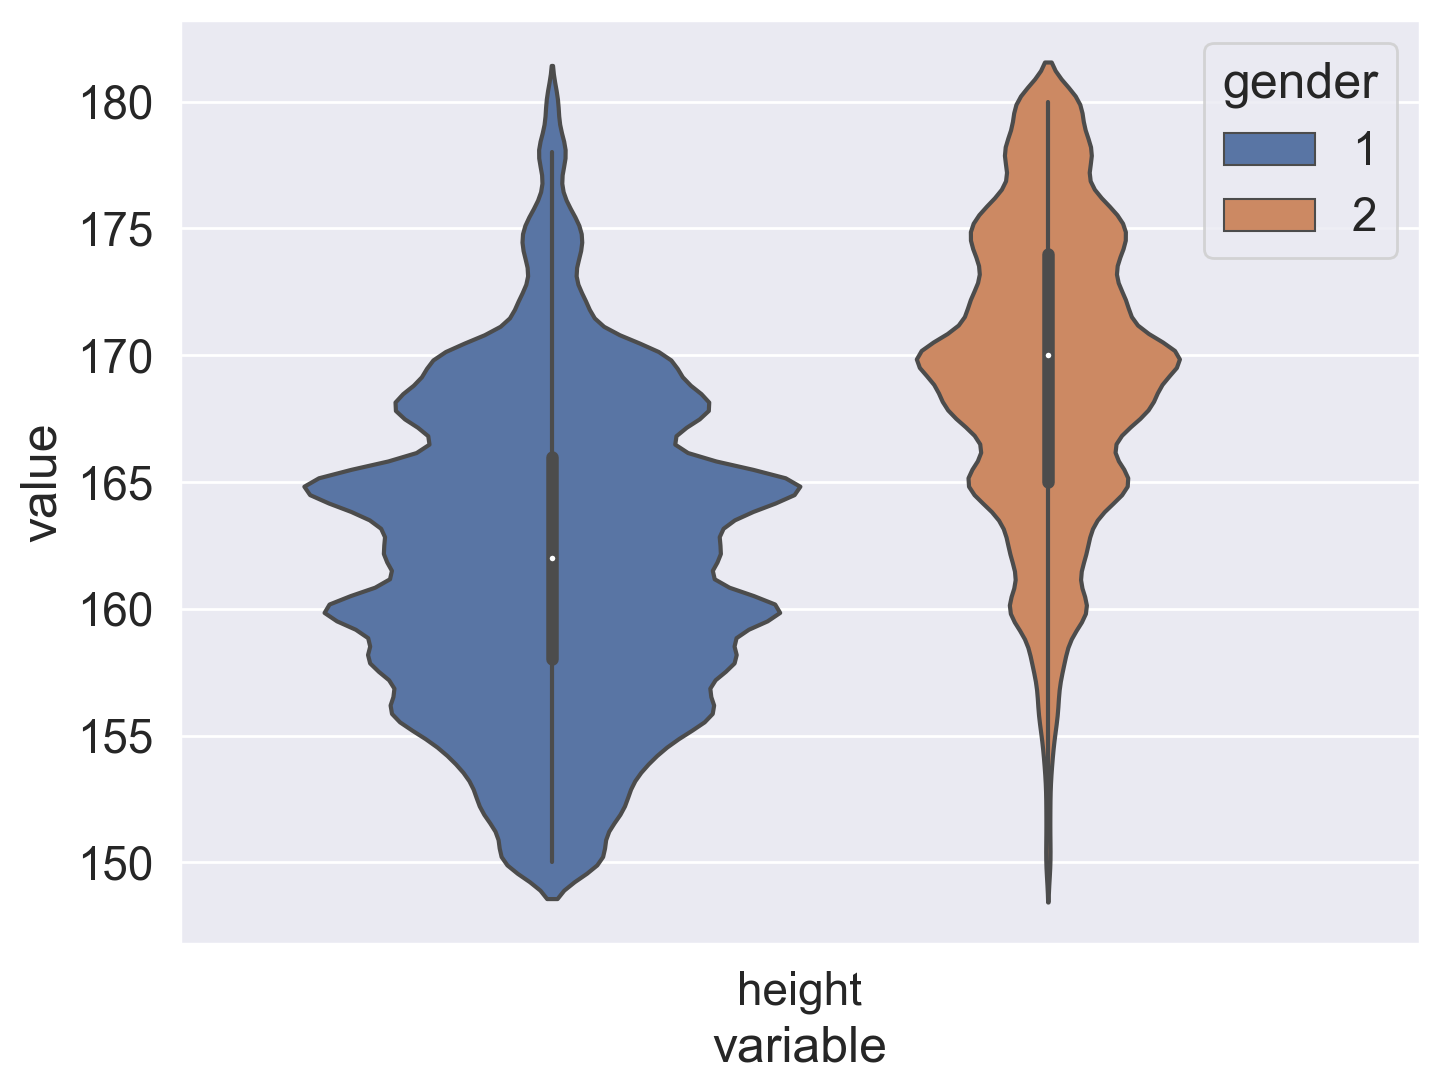

In [31]:
df_melted = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])

_, axis = plt.subplots(figsize=(8,6))
sns.violinplot(x='variable', y='value', scale='count', hue='gender', data=df_melted, ax=axis)

## 2.3. Rank correlation

### Calculate and plot a correlation matrix using the Spearman’s rank correlation coefficient.

### Question 2.2. (1 point). Which pair of features has the strongest Spearman rank correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

<AxesSubplot:>

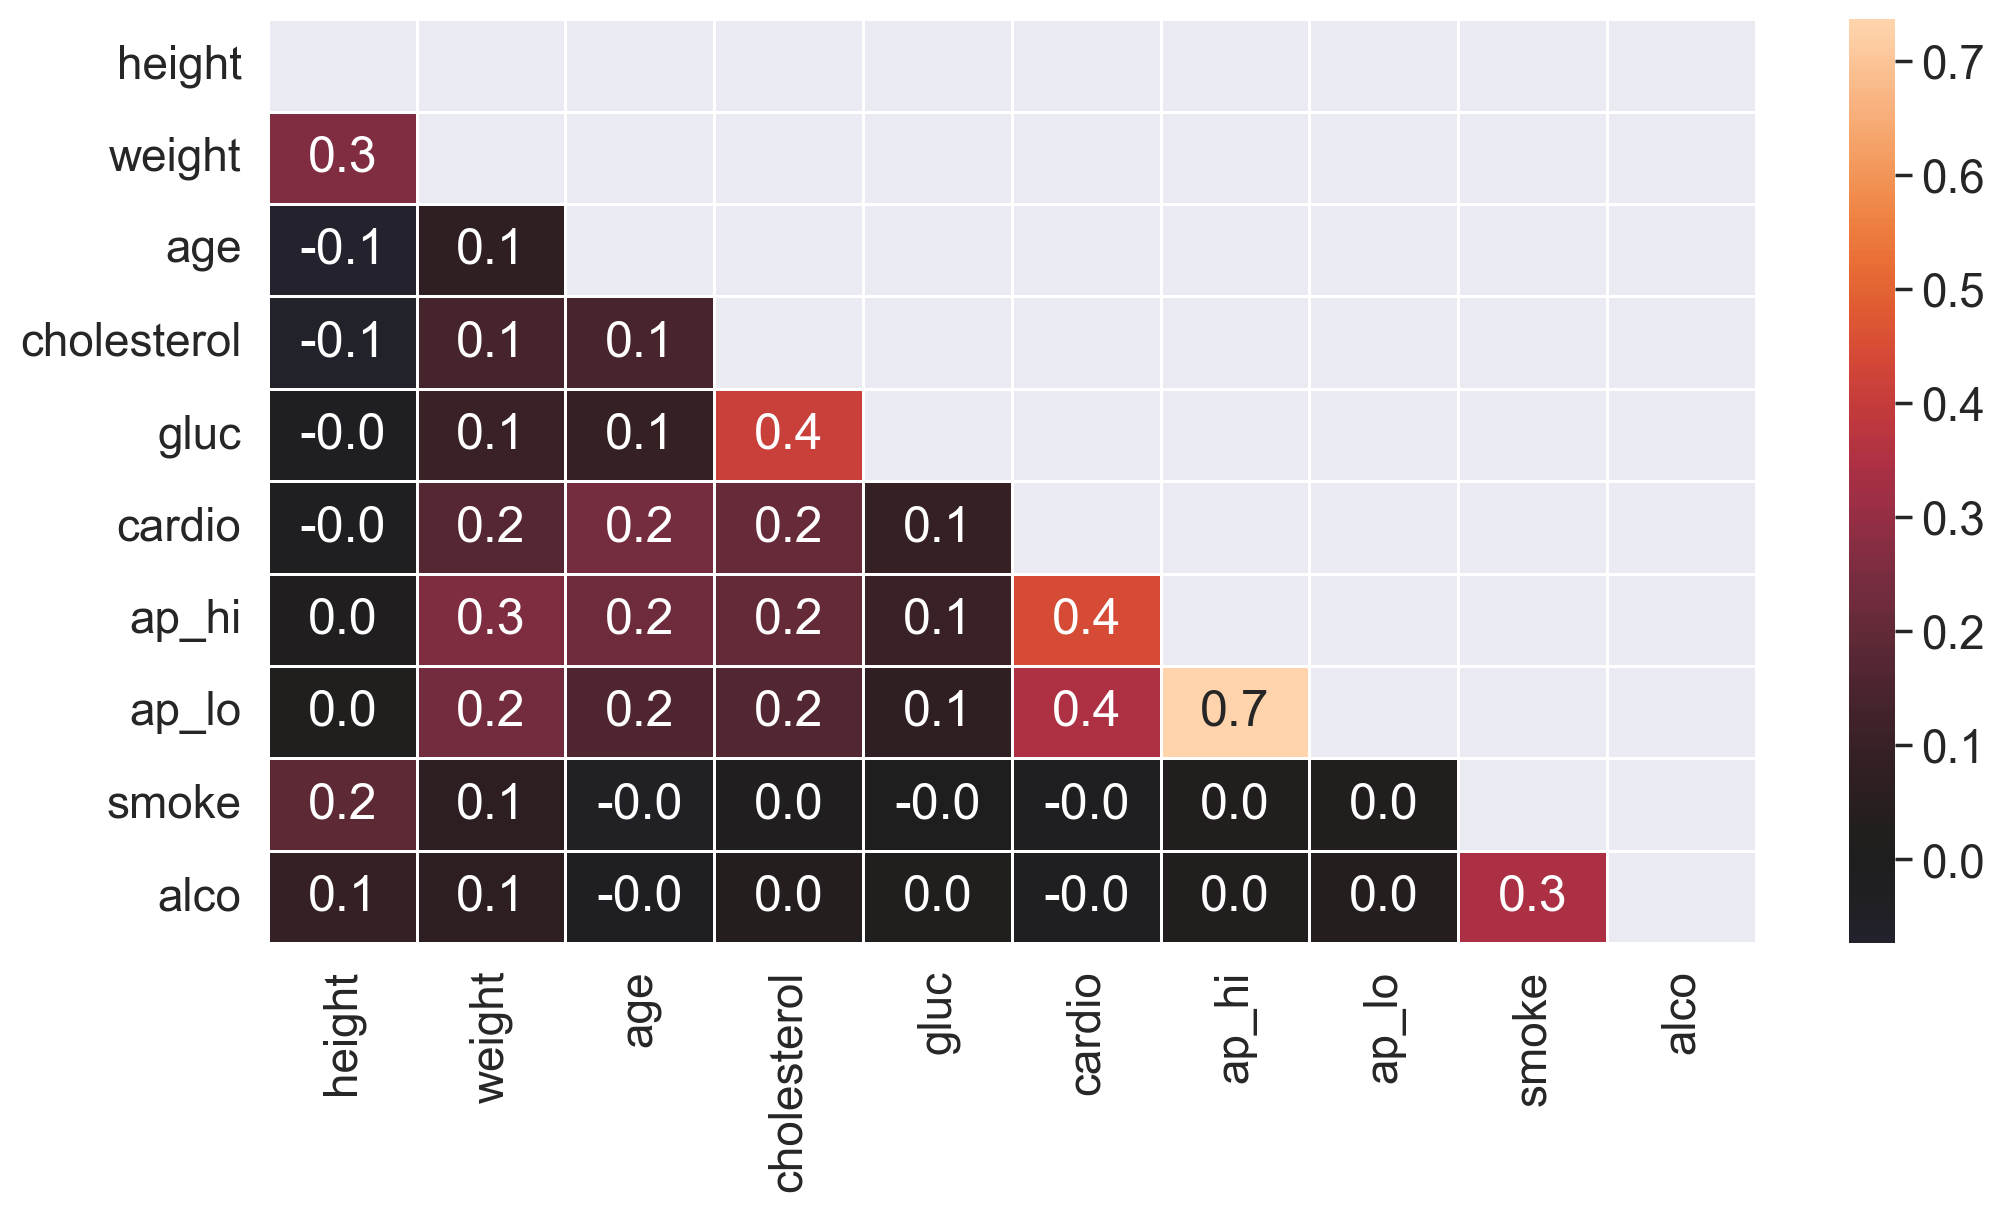

In [32]:
spearman_corr = df[["height", "weight", 'age', 'cholesterol', 'gluc', 'cardio', 'ap_hi', 'ap_lo', 'smoke', 'alco']].corr(method='spearman') 

_, axis = plt.subplots(figsize=(12,6))

mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

sns.heatmap(spearman_corr, fmt='.1f', mask=mask, annot=True,center=0, linewidths=0.5, ax=axis)

answer: 5. Ap_hi, Ap_lo

### Question 2.3. (1 point). Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

answer: 3

## 2.4. Age

Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each cardio class of that age.

<AxesSubplot:xlabel='age_years', ylabel='count'>

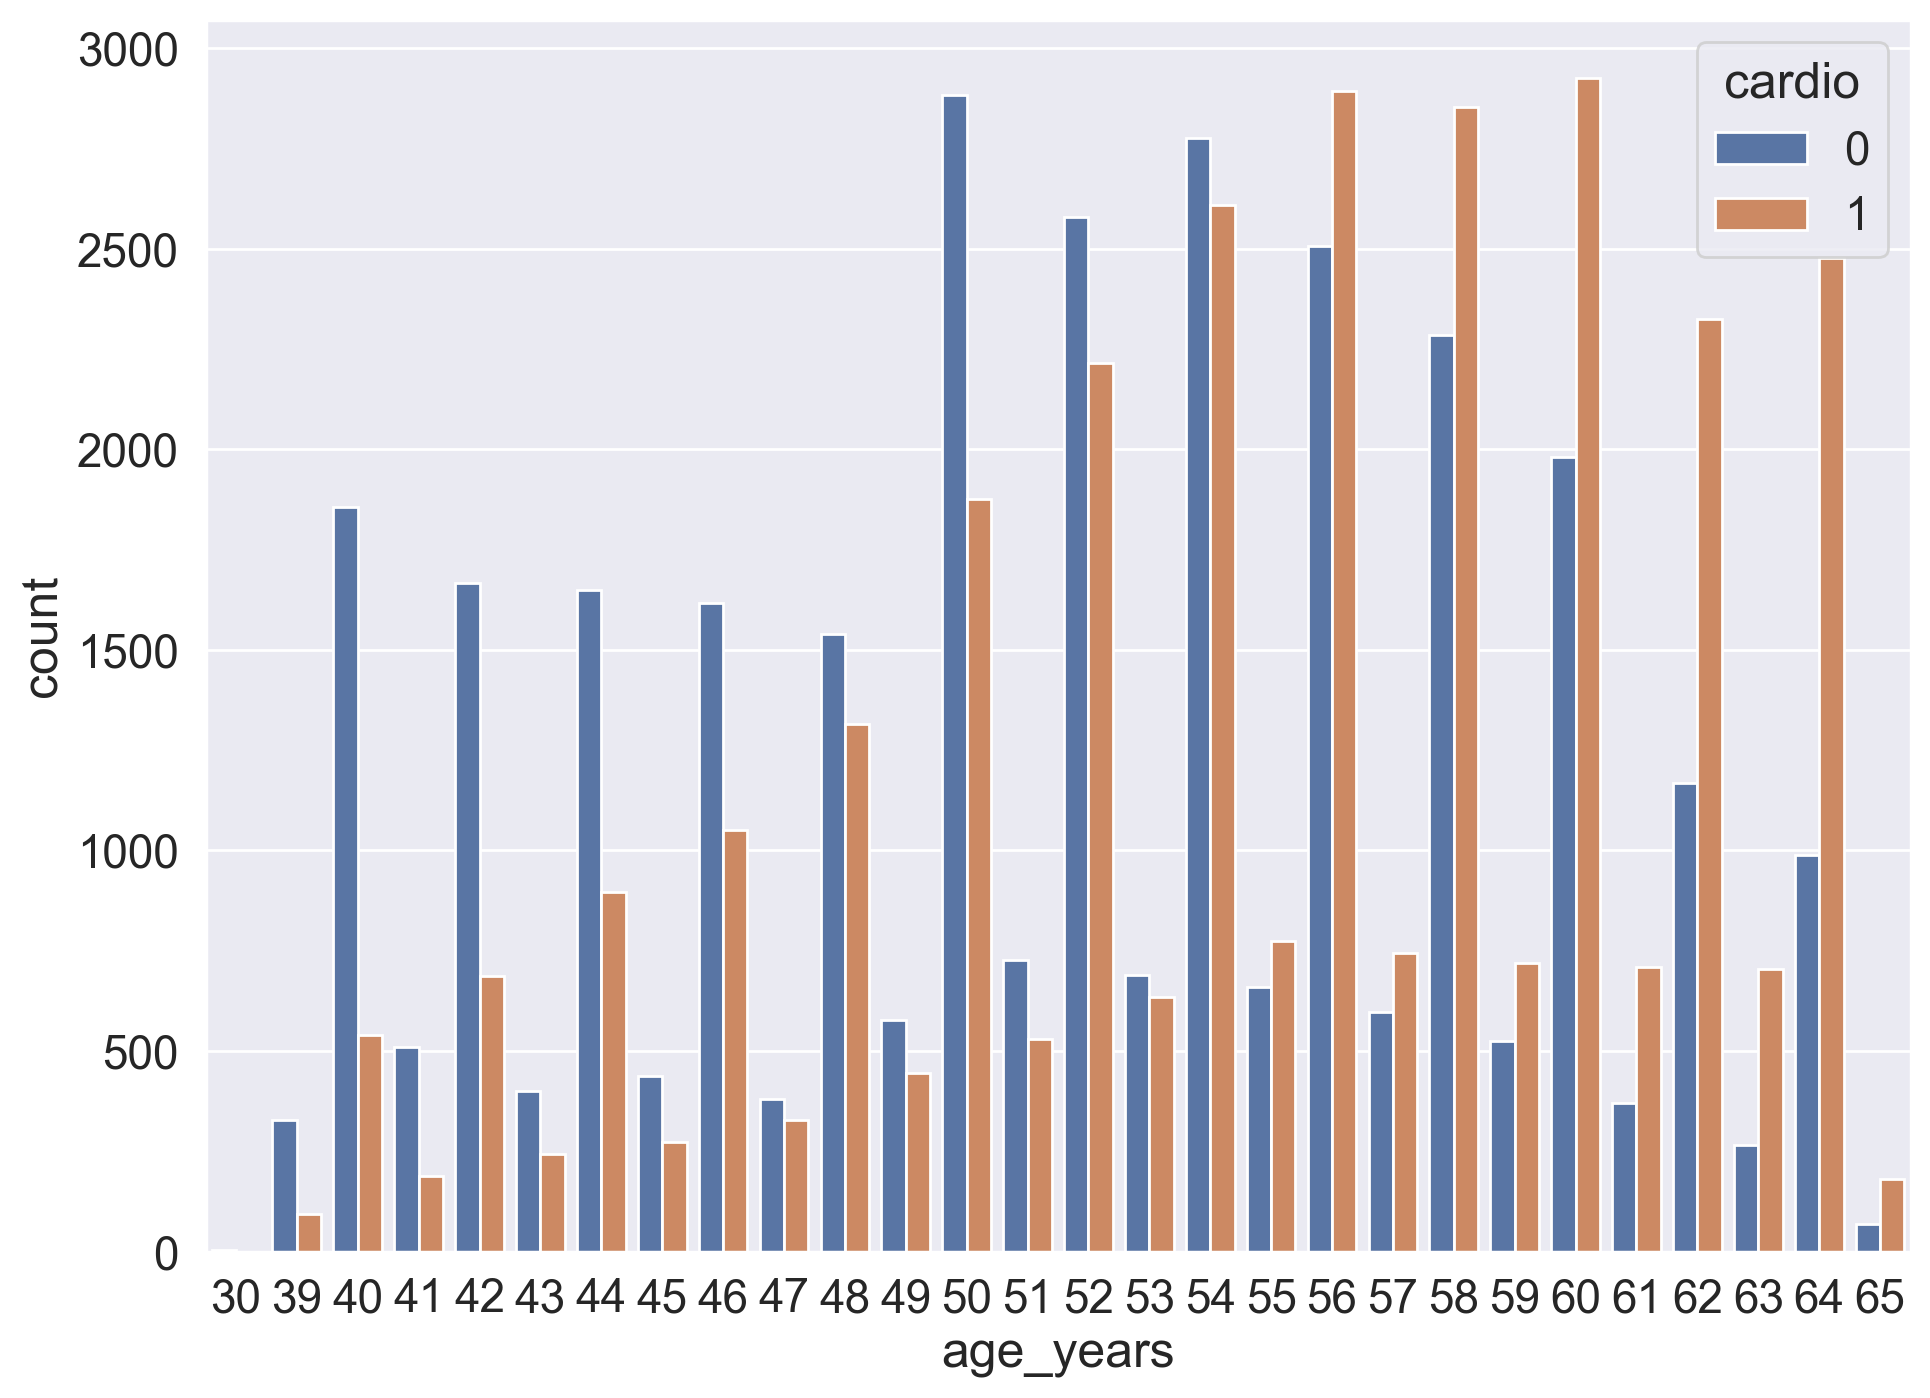

In [33]:
sns.countplot(x="age_years", hue="cardio", data=df)

### Question 2.4. (1 point). What is the smallest age at which the number of people with CVD outnumbers the number of people without CVD?

answer: 55